In [2]:
import os
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from collections import Counter, defaultdict
from PIL import Image, ExifTags
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/ice1187/car-final/pyenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


### TSR Model: CNN

In [78]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 43)  # GTSRB has 43 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Transformations for the dataset
cnn_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [79]:
resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
resnet.maxpool = nn.Identity()
resnet.fc = nn.Linear(resnet.fc.in_features, 43)

resnet_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [80]:
vgg = models.vgg16(weights='IMAGENET1K_V1')
vgg.classifier[6] = nn.Linear(4096, 43)

vgg_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [81]:
VIT = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=43, ignore_mismatched_sizes=True)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([43]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([43, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
model_type = 'cnn'

if model_type == 'resnet':
    model = resnet
    transform = resnet_transform
if model_type == 'vgg':
    model = vgg 
    transform = vgg_transform
elif model_type == 'vit':
    print('[!] should not be used!')
    model = VIT
    transform = vit_transform
else:
    model = CNN()
    transform = cnn_transform
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=43, bias=True)
)

### Prepare Dataset

In [27]:
# Function to correct orientation based on EXIF data
def correct_orientation(image):
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = image._getexif()
        if exif is not None:
            orientation = exif.get(orientation)
            if orientation == 3:
                image = image.rotate(180, expand=True)
            elif orientation == 6:
                image = image.rotate(270, expand=True)
            elif orientation == 8:
                image = image.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        pass
    return image

# Function to load label to image paths
def load_label2image_paths(base_path):
    label2image_paths = defaultdict(list)

    def recurse(current_path, current_label):
        for entry in os.listdir(current_path):
            entry_path = os.path.join(current_path, entry)
            if os.path.isdir(entry_path):
                new_label = current_label + [entry]
                recurse(entry_path, new_label)
            elif entry.lower().endswith('.jpg'):
                label = '_'.join(current_label)
                label2image_paths[label].append(entry_path)

    recurse(base_path, [])
    return label2image_paths

# Custom ImageFolder to include orientation correction
class CustomImageFolder(ImageFolder):
    def __init__(self, label2image_paths, transform=None):
        self.label2image_paths = label2image_paths
        self.samples = [(path, label) for label, paths in label2image_paths.items() for path in paths]
        self.classes = list(label2image_paths.keys())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        with open(path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')
            img = correct_orientation(img)
        if self.transform is not None:
            img = self.transform(img)
        label_idx = self.class_to_idx[label]
        return img, label_idx

# Load label to image paths
label2image_paths = load_label2image_paths("data/real-world/processed")

# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
])

# Load the dataset using CustomImageFolder
dataset = CustomImageFolder(label2image_paths, transform=transform)

# Create data loader
data_loader = DataLoader(dataset) #, batch_size=32 , shuffle=True, num_workers=4, pin_memory=True)

# Function to show random images from the dataset
def show_random_images(data_loader, num_images=10):
    # Get a batch of images and labels
    images, labels = next(iter(data_loader))
    
    # Select random indices from the batch
    indices = random.sample(range(len(images)), num_images)
    selected_images = images[indices]
    selected_labels = [dataset.classes[labels[idx]] for idx in indices]

    # Calculate subplot size
    subplot_size = int(num_images ** 0.5)

    # Set up plot layout
    fig, axs = plt.subplots(nrows=subplot_size, ncols=subplot_size, figsize=(20, 12))

    # Show images and labels
    for ax, img, label in zip(axs.ravel(), selected_images, selected_labels):
        img = img.permute(1, 2, 0)  # Convert to HWC format
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        img = img.clip(0, 1)
        ax.imshow(img)
        ax.set_title(label, fontsize=10)  # Set label, adjust font size
        ax.axis('off')

    # Adjust subplot spacing and layout
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.tight_layout()
    plt.show()

# Test the function by showing random images
print(len(data_loader))
#show_random_images(data_loader, num_images=10)

2989


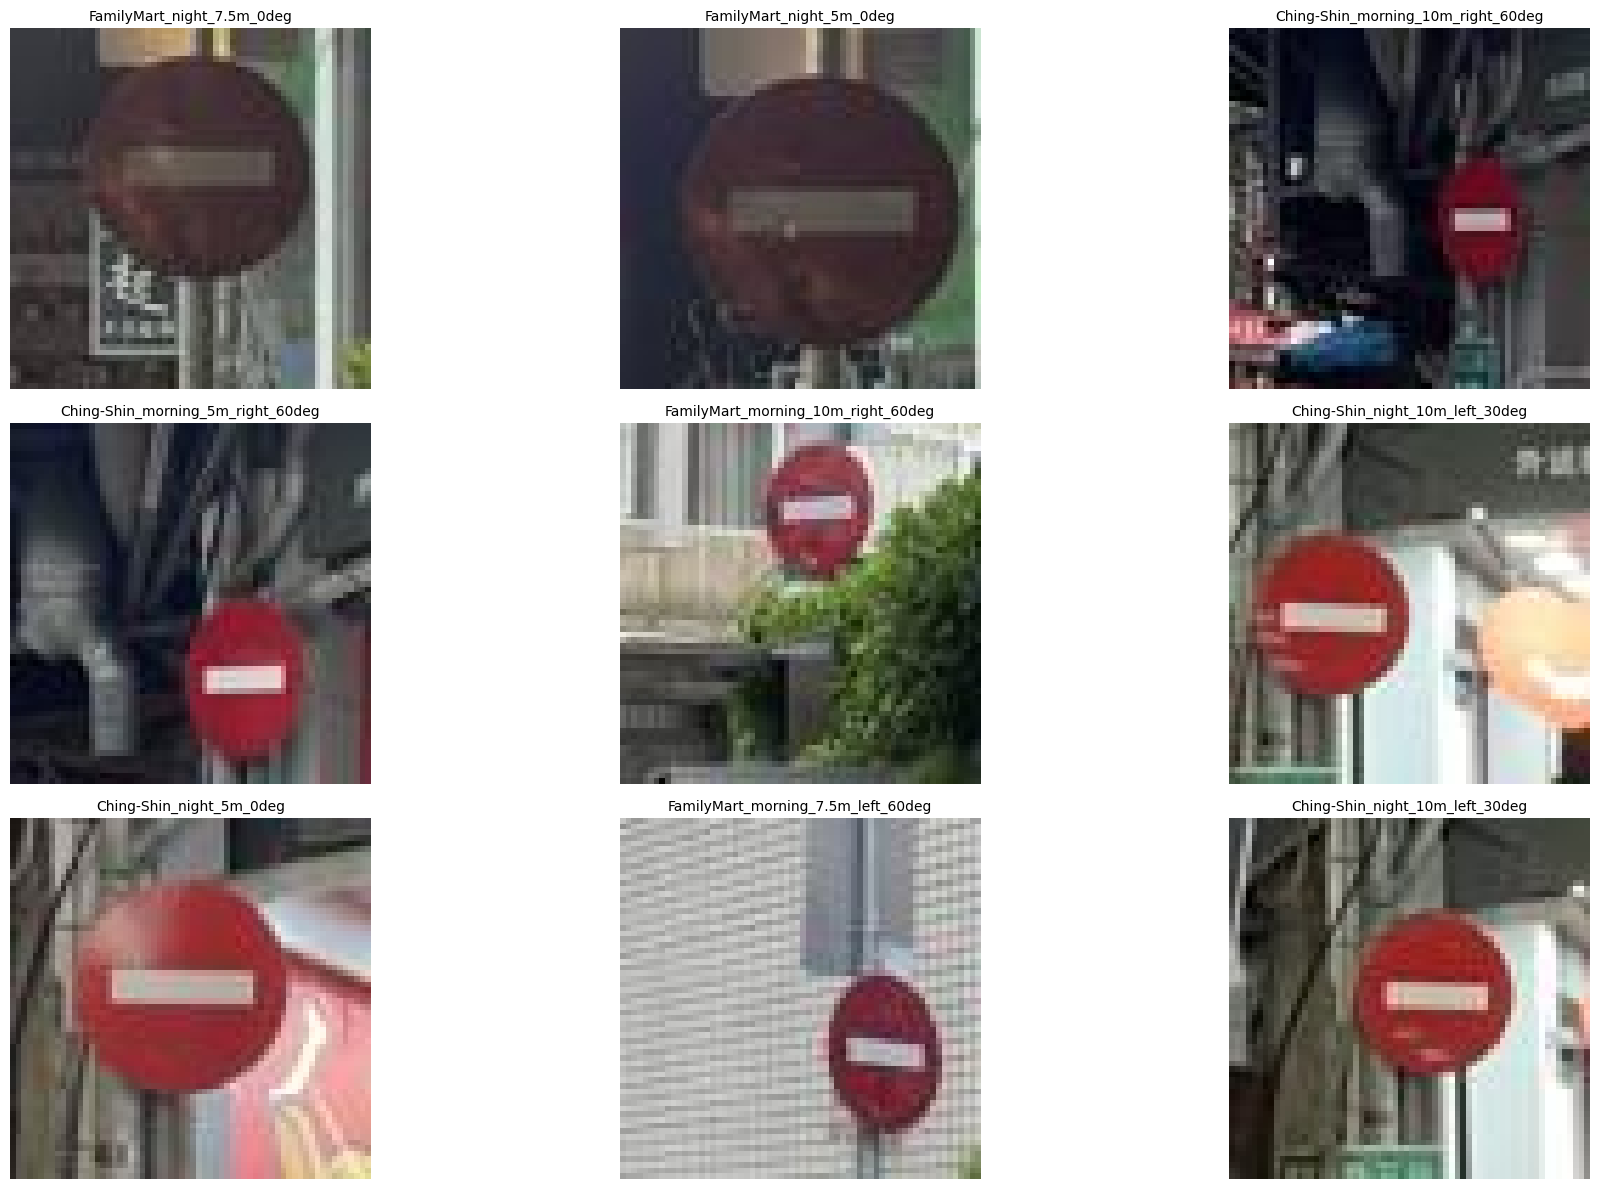

In [106]:
show_random_images(label2images, 10)

In [83]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

100%|████████████████████████████████████████████████████████████████████████████| 39209/39209 [00:08<00:00, 4402.55it/s]


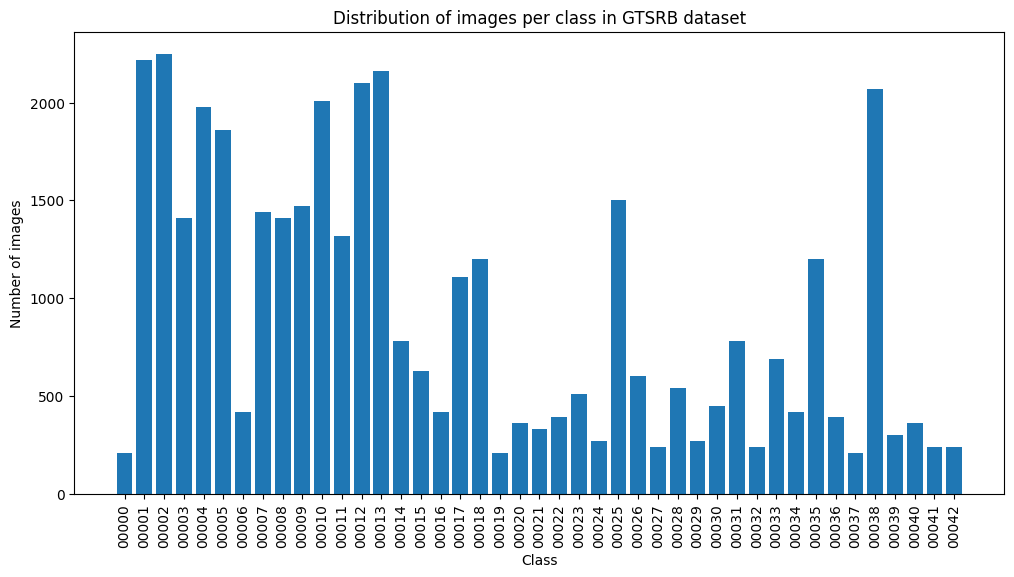

In [84]:
# Count the number of images per class
class_counts = Counter([label for _, label in tqdm(dataset)])

# Get class names from the dataset
class_names = [dataset.classes[idx] for idx in class_counts.keys()]

# Plot the distribution of images per class
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Distribution of images per class in GTSRB dataset')
plt.xticks(rotation=90)
plt.show()

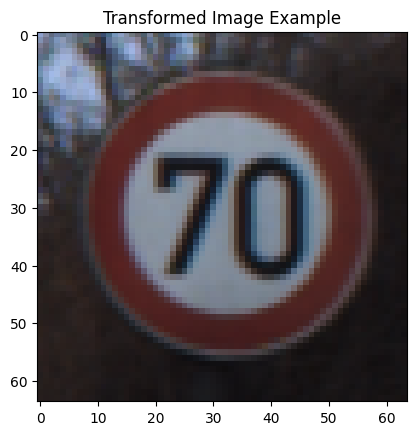

In [85]:
def show_image(image):
    image = image.numpy().transpose((1, 2, 0))
    image = (image * 0.5) + 0.5  # Unnormalize
    plt.imshow(image)
    plt.title('Transformed Image Example')
    plt.show()
    
example_image, _ = train_dataset[0]
show_image(example_image)

### Training & Evaluation

In [86]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5

if model_type == 'resnet' or model_type == 'vgg':
    num_epochs = 3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Initialize the model, loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [87]:
# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        if model_type == 'vit':
            outputs = model(images).logits
        else:
            outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.2%}')

100%|██████████████████████████████████████████████████████████████████████████████████| 491/491 [00:07<00:00, 63.82it/s]


Epoch 1/5, Loss: 0.9493, Accuracy: 7212.36%


100%|██████████████████████████████████████████████████████████████████████████████████| 491/491 [00:07<00:00, 63.76it/s]


Epoch 2/5, Loss: 0.1283, Accuracy: 9631.14%


100%|██████████████████████████████████████████████████████████████████████████████████| 491/491 [00:07<00:00, 64.13it/s]


Epoch 3/5, Loss: 0.0620, Accuracy: 9819.56%


100%|██████████████████████████████████████████████████████████████████████████████████| 491/491 [00:07<00:00, 63.85it/s]


Epoch 4/5, Loss: 0.0474, Accuracy: 9873.12%


100%|██████████████████████████████████████████████████████████████████████████████████| 491/491 [00:07<00:00, 64.25it/s]

Epoch 5/5, Loss: 0.0362, Accuracy: 9893.20%


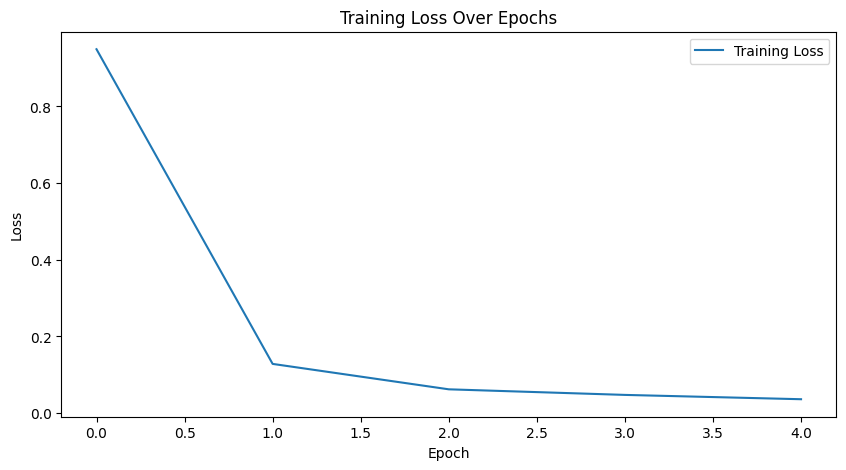

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [98]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        if model_type == 'vit':
            outputs = model(images).logits
        else:
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {correct / total:.2%}')

100%|█████████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 128.43it/s]

Accuracy: 98.70%


### Attack
- patch size
- patch position
- patch transparency (alpha)

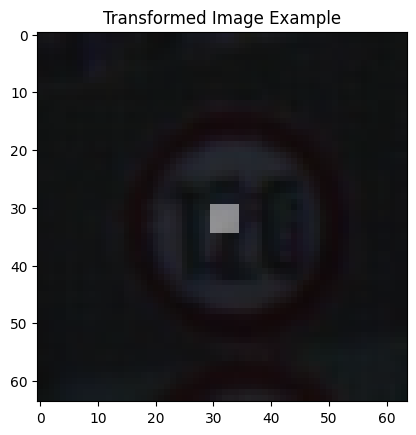

In [90]:
def add_white_rectangle(image, rect_size=(5, 5), position=(30, 30), alpha=0.5):
    image = image.clone()
    for c in range(image.size(0)):  # Iterate over color channels
        image[c, position[0]:position[0]+rect_size[0], position[1]:position[1]+rect_size[1]] = \
            alpha * 1.0 + (1 - alpha) * image[c, position[0]:position[0]+rect_size[0], position[1]:position[1]+rect_size[1]]
    return image

example_image, _ = val_dataset[1]
patch_image = add_white_rectangle(example_image)
show_image(patch_image)

In [96]:
# Evaluation after Attack 
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        images = torch.stack([add_white_rectangle(img) for img in images])
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy: {correct / total:.2%}')

100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 63.30it/s]

Accuracy: 80.85%


In [99]:
# Attack: Different Transparecy
model.eval()

alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
accuracies = []
for alpha in alphas:
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            images = torch.stack([add_white_rectangle(img, alpha=alpha) for img in images])
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f'Alpha: {alpha}, Accuracy: {accuracy:.2%}')

100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 64.00it/s]


Alpha: 0.0, Accuracy: 98.70%


100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 64.63it/s]


Alpha: 0.2, Accuracy: 92.80%


100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 65.38it/s]


Alpha: 0.4, Accuracy: 84.75%


100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 64.20it/s]


Alpha: 0.6, Accuracy: 77.66%


100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 63.55it/s]


Alpha: 0.8, Accuracy: 71.00%


100%|██████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 62.59it/s]

Alpha: 1.0, Accuracy: 64.46%


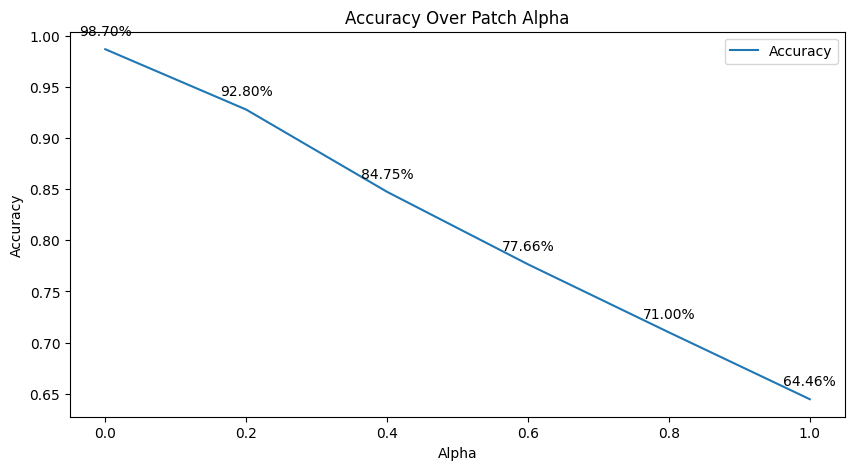

In [101]:
plt.figure(figsize=(10, 5))
plt.plot(alphas, accuracies, label='Accuracy')
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt:.2%}', (alphas[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Patch Alpha')
plt.legend()
plt.show()